In [26]:
import torch
from math import e

import matplotlib.pyplot as plt
import matplotx
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#mpl.use('Qt5Agg')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['figure.dpi'] = 200
custom_colors = {
    "Blue": "#61AFEF",
    "Orange": "#D49F6E",
    "Green": "#98C379",
    "Rose": "#E06C75",
    "Purple": "#C678DD",
    "Gold": "#E5C07B",
    "Cyan": "#36AABA",

    0: "#61AFEF",
    1: "#D49F6E",
    2: "#98C379",
    3: "#E06C75",
    4: "#C678DD",
    5: "#E5C07B",
    6: "#36AABA",

    "LightCyan": "#56B6C2",


    "AltOrange": "#D19A66",
    "Red": "#BE5046",


    "RoyaBlue": "#528BFF",

    "Gray": "#ABB2BF",
    "LightGray": "#CCCCCC",

    "LightBlack": "#282C34",
    "Black": "#1D2025"
}
plt.style.use(matplotx.styles.onedark)

cmap = LinearSegmentedColormap.from_list('mycmap', [custom_colors[i] for i in range(2)])
cmap_2 = ListedColormap([custom_colors[i] for i in range(5)])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def multiQuad_kernel(x: torch.tensor, radius: float):
    return torch.sqrt(1 + (16*x/radius)**2)


torch.cuda.get_device_name(device)

'NVIDIA GeForce GTX 1660 Ti'

In [209]:
#Datos muestreados
x_0 = torch.linspace(-5, 5, 15, device=device)
y_0 = torch.linspace(-5, 5, 15, device=device)

#x_0, y_0 = np.meshgrid(x_0, y_0)
x_0, y_0 = torch.meshgrid(x_0, y_0, indexing='xy')
z = 1 - abs(x_0+y_0)-abs(y_0-x_0)

pairs = torch.stack([x_0.ravel(), y_0.ravel()]).T

# Variables
size = x_0.size(dim=0)
radius = 10

In [210]:
# Inicio del método para la interpolación con RBF
phi_matrix = torch.stack([multiQuad_kernel(torch.linalg.vector_norm(pairs - pos, dim=1), radius) for pos in pairs])
weights_matrix = torch.linalg.solve(phi_matrix, z.ravel())

In [211]:
# Función interpolada
def interpolate(x: torch.tensor, radius: float) -> torch.tensor:
    temp = 0
    for (rbf_pos, w) in zip(pairs, weights_matrix):
        temp += w * multiQuad_kernel(torch.linalg.vector_norm(x - rbf_pos), radius)
    return temp

In [335]:
# Función interpolada alterna
def interpolate_alt(x: torch.tensor, radius: float) -> torch.tensor:
    temp = torch.stack([torch.linalg.vector_norm(torch.sub(x, pos), dim=1) for pos in pairs])
    temp = multiQuad_kernel(temp, radius)
    return torch.matmul(temp.T, weights_matrix)

In [346]:
# Interpolación
step = 50

x_RBF = torch.linspace(-5, 5, step, device=device)
y_RBF = torch.linspace(-5, 5, step, device=device)
x_RBF, y_RBF = torch.meshgrid(x_RBF, y_RBF, indexing='xy')

pairs_2 = torch.stack([x_RBF.ravel(), y_RBF.ravel()]).T

In [347]:
a=torch.stack([torch.linalg.vector_norm(torch.sub(pairs_2, pos), dim=1) for pos in pairs])
a = multiQuad_kernel(a, radius)
b = torch.matmul(a.T, weights_matrix)
#z_RBF = b

In [312]:
#z_RBF = torch.matmul(multiQuad_kernel(torch.stack([torch.linalg.vector_norm(torch.sub(pairs_2, pos), dim=1) for pos in pairs]), radius).T, weights_matrix)

In [351]:
z_RBF = interpolate_alt(pairs_2, radius)

In [352]:
z_RBF = torch.reshape(z_RBF, x_RBF.shape)

torch.Size([50, 50])

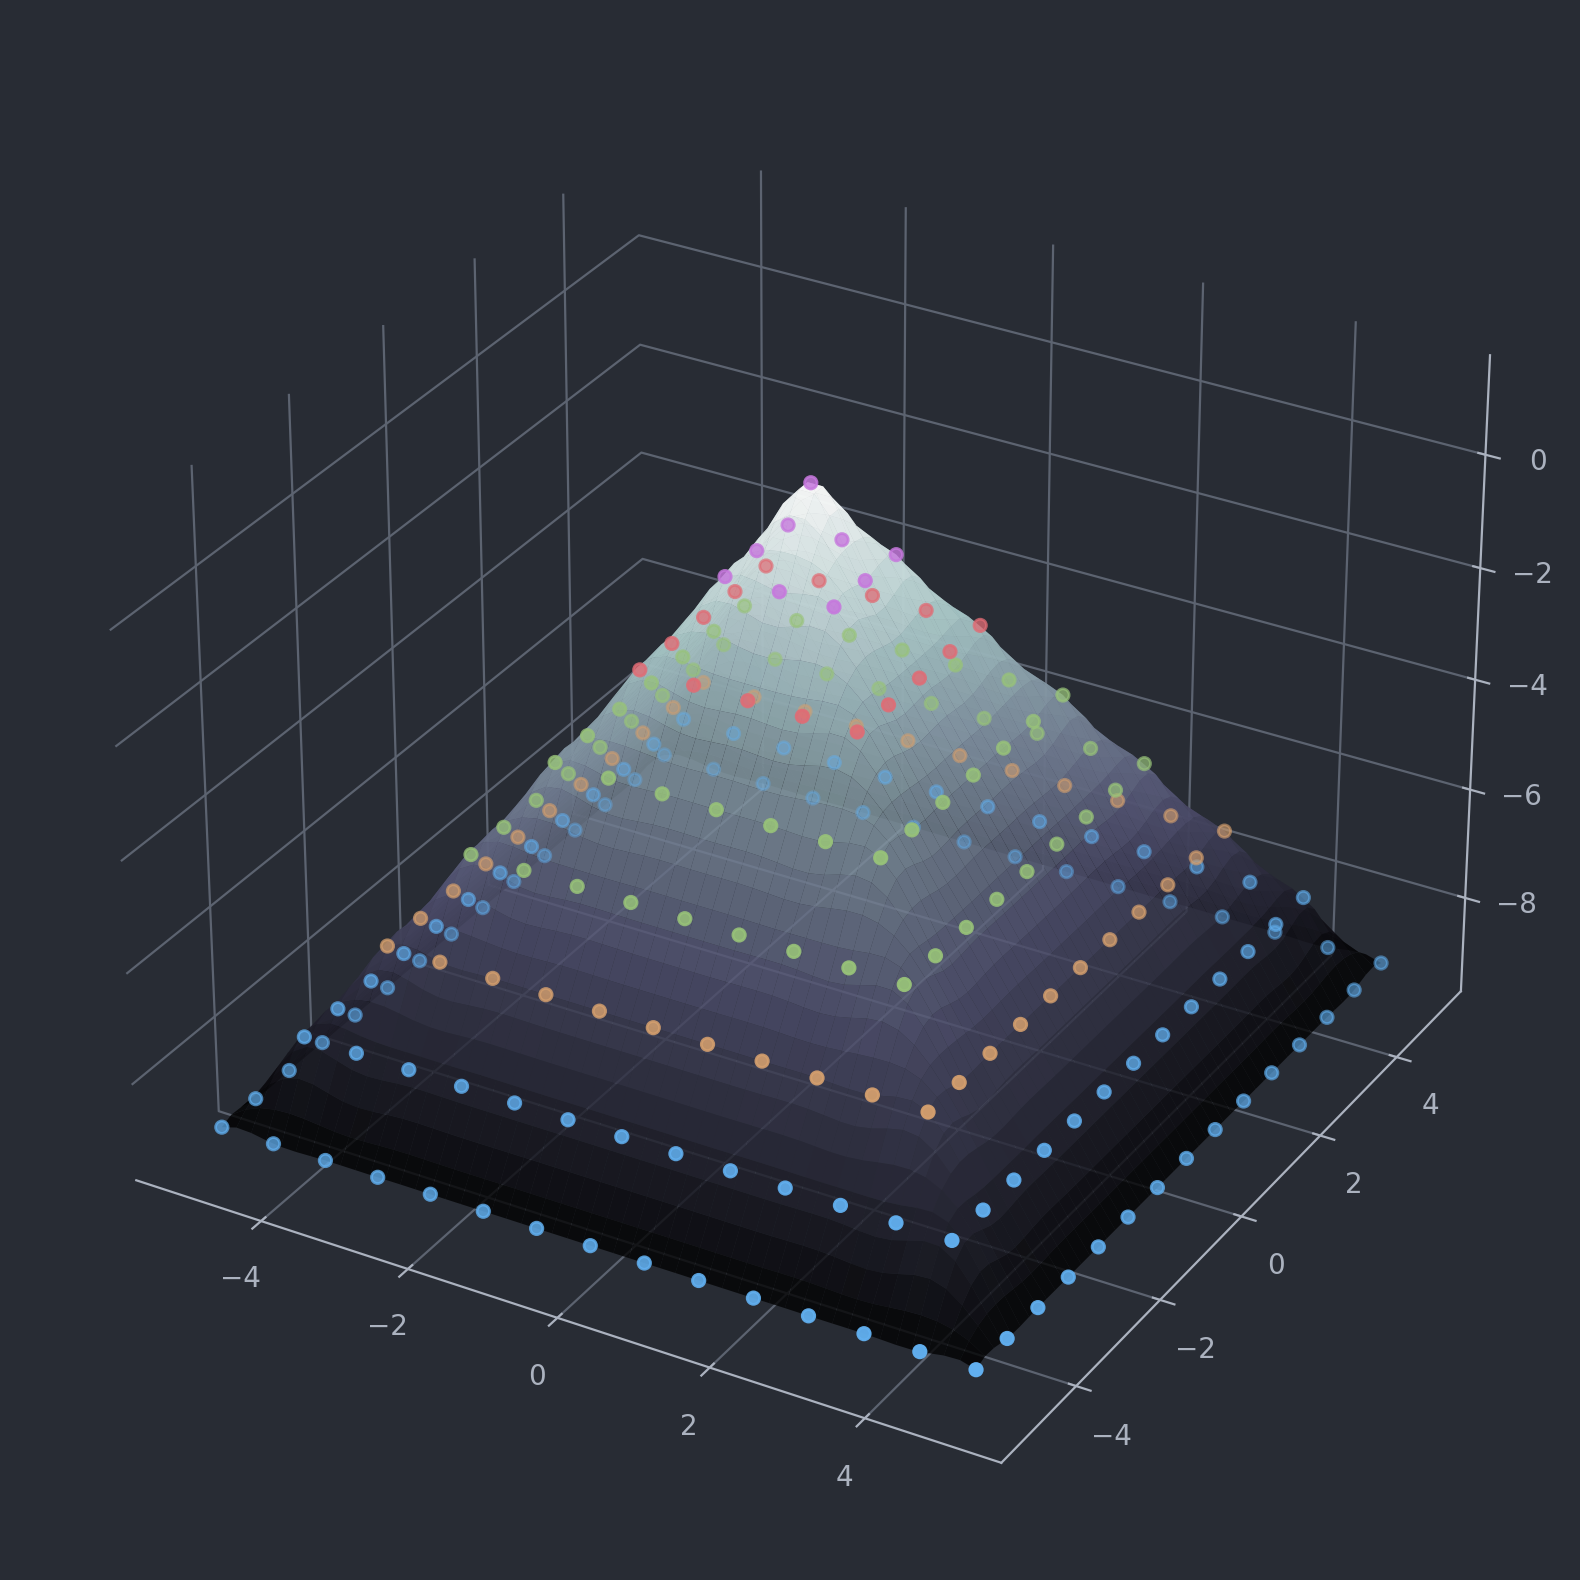

In [353]:
# Plotting
ax = plt.axes(projection="3d")
surf = ax.plot_surface(x_RBF.cpu().detach().numpy(), y_RBF.cpu().detach().numpy(), z_RBF.cpu().detach().numpy(), cmap=cm.bone, antialiased=True, alpha=0.8, zorder=1)
scat = ax.scatter3D(x_0.cpu().detach().numpy(), y_0.cpu().detach().numpy(), z.cpu().detach().numpy(), c=z.cpu().detach().numpy(), cmap=cmap_2)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

plt.show()